# Source-Photometry Lephare Identification Tool (SPLIT) for star-galaxy separation

A code to perform star-galaxy separation from LSST photometric data. This notebook helped with the development of the code in Python (for the moment),and took over its different parts.

From the observation and analysis led in DES and DC1 results stats for star-gal separation, we incorporate a few tools to flag the type of sources (star or galaxy).

## Initialization

In [1]:
### Load libraries ###

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit

import warnings

## PDZ flagger

Look at the quality of the Redshift Probability Distribution Function (PDZ). Same functions as in  outpout_PDZ_flagger.

In [2]:
def safe_method(f):
    def wrapped(*args, **kwargs):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = f(*args, **kwargs)
                if result is None or not np.isfinite(result):
                    return -99
                return result
        except Exception as e:
            return -99
    return wrapped



class PDZStats:
    """
    A class to compute statistical metrics on LePHARE P(z) distributions
    to estimate quality flags for redshift reliability.
    """

    def __init__(self, zgrid, pdz, z_best=None):
        """
        Initialize with a redshift grid and a normalized P(z).
        """
        self.zgrid = zgrid
        try:
            area = trapezoid(pdz, zgrid)
            if area <= 0 or not np.isfinite(area):
                self.pdz = np.zeros_like(pdz)
                self.valid = False
            else:
                with np.errstate(divide='ignore', invalid='ignore'):
                    self.pdz = pdz / area
                self.valid = True
        except Exception:
            self.pdz = np.zeros_like(pdz)
            self.valid = False

        self.z_best = z_best if z_best is not None else self.zgrid[np.argmax(self.pdz)]

    def zbest(self):
        return self.z_best

    @safe_method
    def error(self):
        """Compute sigma of the P(z)"""
        var = trapezoid((self.zgrid - self.z_best) ** 2 * self.pdz, self.zgrid)
        return np.sqrt(var)

    @safe_method
    def sigma(self):
        """Fit a Gaussian to estimate the width"""
        def gauss(z, A, mu, sigma):
            with np.errstate(divide='ignore', invalid='ignore'):
                return A * np.exp(-(z - mu)**2 / (2 * sigma**2))

        err = self.error()
        if err == -99:
            return -99

        mask = (self.zgrid >= self.z_best - err) & (self.zgrid <= self.z_best + err)
        pdz_local = np.where(mask, self.pdz, 0.0)
        p0 = [np.max(pdz_local), self.z_best, err]
        popt, _ = curve_fit(gauss, self.zgrid, pdz_local, p0=p0, maxfev=5000)
        _, _, siga_fit = popt
        return abs(siga_fit)

    @safe_method
    def number_mod(self, threshold=0.75):
        """Count significant local maxima"""
        peaks, _ = find_peaks(self.pdz, height=threshold * max(self.pdz))
        return len(peaks)

    @safe_method
    def peak_ratio(self):
        """Ratio of mean(pdz) to max(pdz)"""
        return np.mean(self.pdz) / max(self.pdz)

    @safe_method
    def tail_mass(self, n_window=2, good_sigma=0.01):
        """
        Compute the total probability mass in the tails, outside a window around z_best.
        """
        window = self.sigma()
        if window == -99:
            return -99
        if window <= good_sigma and window >= 0:
            return 0
        mask = (self.zgrid < self.z_best - n_window * window) | (self.zgrid > self.z_best + n_window * window)
        return trapezoid(np.where(mask, self.pdz, 0.0), self.zgrid)

In [3]:
def compute_pdz_score(pdz, zgrid, nb_peak_thresh=1, height_thresh=0.5, tail_thresh=0.2, peak_ratio_thresh=0.25, error_thresh=0.2, z_best=None):  
    """
    Returns a 4-bit integer score (0-31), higher = worse.
    Bitwise impact order: number_mod (8), tail_mass (4), peak_ratio (2), error (1), very_bad_error (16)
    """
    pdz_stats = PDZStats(zgrid, pdz, z_best)

    score = 0
    invalid = False  # Flag if one fails

    zbest = pdz_stats.zbest()
    number_mod = pdz_stats.number_mod(threshold=height_thresh)
    tail_mass = pdz_stats.tail_mass()
    peak_ratio = pdz_stats.peak_ratio()
    error = pdz_stats.error()
    sigma = pdz_stats.sigma()

    if number_mod == 0 or number_mod ==-99:
        invalid = True

    # Score bitwise
    if error != -99 and error > error_thresh and error < np.max(zgrid)/2:
        score += 1

    if peak_ratio != -99 and peak_ratio > peak_ratio_thresh:
        score += 2

    if tail_mass != -99 and tail_mass > tail_thresh:
        score += 4

    if number_mod != -99 and number_mod > nb_peak_thresh:
        score += 8

    if error != -99 and error > np.max(zgrid)/2.5:
        score += 16  # Worst case error

    # Optionnel : si tout a foiré → renvoyer score maximal
    if invalid:
        score = -99
    return int(score), zbest, error, peak_ratio, tail_mass, number_mod, sigma


(9,
 np.float64(0.54),
 np.float64(0.22816266991825207),
 np.float64(0.01741057603072399),
 0,
 2,
 np.float64(0.004489835820504709))

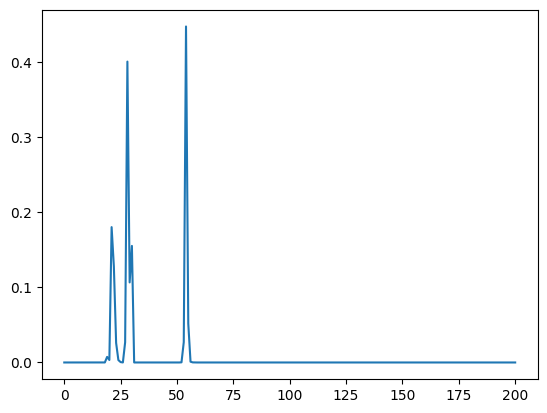

In [4]:
# pdz_test = [0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00 ]
pdz_test = [2.2106e-73,2.0494e-61,2.0866e-53,2.6825e-46,1.4931e-40,6.6038e-37,9.5695e-35,7.1543e-35,1.5583e-27,1.9197e-21,2.7110e-18,2.0897e-15,3.0888e-11,3.6508e-10,6.1314e-10,1.3886e-08,9.1291e-11,9.6957e-08,4.3445e-05,7.4334e-03,3.3127e-03,1.8049e-01,1.2800e-01,2.6047e-02,3.2014e-03,4.9569e-04,4.4838e-05,2.6980e-02,4.0119e-01,1.0675e-01,1.5544e-01,1.1139e-05,9.1965e-07,4.0231e-09,7.8726e-09,1.0631e-10,1.7470e-12,1.5424e-14,1.2428e-13,2.1042e-12,1.0333e-12,2.6416e-12,2.9561e-09,8.6772e-09,2.4909e-10,1.2298e-13,8.9521e-16,4.4817e-15,1.7999e-14,4.1041e-11,2.3026e-08,1.5452e-06,2.0037e-04,2.7080e-02,4.4802e-01,5.1941e-02,1.0492e-03,1.2415e-04,5.8517e-07,7.6230e-12,2.8948e-18,9.1393e-25,2.2636e-33,1.1489e-43,5.7009e-55,8.1010e-68,2.1819e-83,1.1722e-101,3.9373e-116,8.5817e-136,7.1630e-158,1.4294e-178,8.9482e-200,4.6958e-219,5.2114e-238,1.1786e-257,5.7375e-285,1.5489e-312,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00]
plt.plot(pdz_test)
### zgrid
ZMIN, ZMAX, ZSTEP = 0, 2, 0.01
z_grid = np.arange(ZMIN, ZMAX + ZSTEP, ZSTEP)
compute_pdz_score(pdz_test, z_grid)

## PDF_Star


Use the Probability Distribution Function VS the spectral-type of stars as an indicator

In [5]:
def get_SP_list(list_path):
    #Get Spectral type of star sed from the sed.list
    spectral_list = []
    with open(list_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            filepath = line.split()[0]
            sp_type = filepath.split('/')[-1].replace('.sed', "")  # Ex: o5v
            spectral_list.append(sp_type)
    return spectral_list



In [29]:
class STAR_PDF_stats:
    """
    A class to compute statistical metrics on LePHARE P(spectral-type) distributions
    to estimate quality flag as a star.
    """

    def __init__(self, pdf):
        self.pdf = pdf

    @safe_method
    def number_mod(self, threshold):
        """Count significant local maxima"""
        max_val = max(self.pdf)
        if max_val == 0:
            return -99
        peaks, _ = find_peaks(self.pdf, height=threshold * max_val)
        return len(peaks)

    @safe_method
    def peak_ratio(self):
        """Ratio of mean to the max(pdf)"""
        max_val = max(self.pdf)
        if max_val == 0:
            return -99
        return np.mean(self.pdf) / max_val

    def spectral_type(self, sed_list=None):
        """Get corresponding spectral type from given SED list"""
        if self.number_mod(0.1) < 1:#arbitray value, we just want to check if there is a peak
            return -99
        if sed_list is None:
            return -99
        i = np.argmax(self.pdf)
        if i >= len(sed_list):
            return -99
        return sed_list[i]


In [40]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
SED_LIST_path = os.path.join(base_dir, 'simulation_catalogs/DES/DES_STARCAT/WORK_COMPLETE2/lib_bin/DES_STAR.list')
#36566167
pdf_test = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.1307e-01, 1.8693e-01, 1.4800e-06, 5.5098e-194, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00 ]
pdf_test = np.zeros(42)
sed_list = get_SP_list(SED_LIST_path)
star_pdf_stats = STAR_PDF_stats(pdf_test)
print(star_pdf_stats.number_mod(0.5), star_pdf_stats.peak_ratio(), star_pdf_stats.spectral_type(sed_list))

-99 -99 -99


## $\Delta_{\chi_2} = CHI\_STAR - CHI\_GAL$

Compare directly the quality of the fit (given by $\chi_2$) between the best-fit star sed and the best-fit galaxy sed.

In [41]:
def delta_chi(chi_star, chi_gal):
    return chi_star-chigal

## Other output to use ?

SCALE\_BEST, Z_BEST...

## Compute type

In [ ]:
def Compute_Source_Type(pdf, sed_list_path=None, mod_thresh=0.5, ratio_thresh=0.05):

    # init instance
    star_pdf_stats = STAR_PDF_stats(pdf)
    #get number of peak(s)
    number_mod = star_pdf_stats.number_mod(mod_thresh)
    #get ratio
    peak_ratio = star_pdf_stats.peak_ratio()
    
    # get spectral type (optional)
    if sed_list_path is not None:
        SP_list = get_SP_list(sed_list_path)
        sp = star_pdf_stats.spectral_type(SP_list)

    #make flag type
    
    if number_mod == -99 or peak_ratio == -99:
        return "-99" + "," + "None"

    if ((number_mod)<2) and ((peak_ratio) <ratio_thresh):
        flag = "star"
    elif (number_mod >= 2) and (peak_ratio >= ratio_thresh):
        flag = 'gal'
    else:
        flag = 'uncertain'

    if sed_list_path is not None:
        return flag + "," + f"{sp}"
    else:
        return flag + "," + "None"

In [85]:
print(Compute_Source_Type(pdf_test, SED_LIST_path))

-99, None


## Write

In [104]:
def load_and_write(catalog_path, flagged_catalog_path, star_pdf_path=None, pdz_path=None, zgrid=None, sed_list_path=None, compute_pdz_flag=True, compute_source_type=True):
    """
    Load star_PDF, PDZ and catalog files and rewrite catalog with 2 FLAG columns.
    The header is preserved and extended.
    """

    pdz_dict = {}
    pdf_dict = {}

    # Load PDZ
    if compute_pdz_flag and pdz_path:
        pdz_data = np.loadtxt(pdz_path, comments='#')
        pdz_dict = {int(row[0]): compute_pdz_score(row[1:], zgrid)[0] for row in pdz_data}

    # Load Star PDF
    if compute_source_type and star_pdf_path:
        star_pdf_data = np.loadtxt(star_pdf_path, comments='#')
        pdf_dict = {int(row[0]): Compute_Source_Type(row[1:], sed_list_path) for row in star_pdf_data}
        print(pdf_dict)
    with open(catalog_path, 'r') as fin, open(flagged_catalog_path, 'w') as fout:
        for line in fin:
            #Edit header
            if line.startswith('#'):
                if '# IDENT  Z_BEST' in line:
                    if compute_pdz_flag and compute_source_type:
                        line = line.rstrip() + '  PDZ_FLAG  S_TYPE\n'
                    elif compute_pdz_flag:
                        line = line.rstrip() + '  PDZ_FLAG\n'
                    elif compute_source_type:
                        line = line.rstrip() + '  S_TYPE\n'
                fout.write(line)
                continue

            tokens = line.strip().split()
            try:
                ident = int(float(tokens[0]))
            except ValueError:
                continue

            if compute_pdz_flag:
                pdz_score = pdz_dict.get(ident, -1.0)
                tokens.append(f"{pdz_score:.4f}")
            if compute_source_type:
                s_type = pdf_dict.get(ident, -1.0)
                print(s_type)
                tokens.append(f"{s_type}")

            fout.write('          '.join(tokens) + '\n')


## Run

In [ ]:
### Load zphota output catalog(s)
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
### Tests on stars ###
# CAT_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/DESstars_Buzzard_PICKLES_DES.out') #output catalog directory
# PDZ_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/PDZs/DESstars_Buzzard_PICKLES_DES_MIN_ZG.prob')
# STAR_PDF_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/PDFs/DESstars_Buzzard_PICKLES_DES_PDFstar.prob')
# CAT_path_flagged = os.path.join(base_dir, 'simulation_catalogs/star_gal/DESstars_Buzzard_PICKLES_DES_typed.out')

### Tests on galaxies ###
CAT_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/DC1_Buzzard_PICKLES_LSST.out') #output catalog directory
PDZ_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/PDZs/DC1_Buzzard_PICKLES_LSST_MIN_ZG.prob')
STAR_PDF_path = os.path.join(base_dir, 'simulation_catalogs/star_gal/PDFs/DC1_Buzzard_PICKLES_LSST_PDFstar.prob')
CAT_path_flagged = os.path.join(base_dir, 'simulation_catalogs/star_gal/DC1_Buzzard_PICKLES_DES_typed.out')

### Other paths ###
SED_LIST_path = os.path.join(base_dir, 'simulation_catalogs/DES/DES_STARCAT/WORK_COMPLETE2/lib_bin/DES_STAR.list')

### zgrid
ZMIN, ZMAX, ZSTEP = 0, 2, 0.01
z_grid = np.arange(ZMIN, ZMAX + ZSTEP, ZSTEP)


In [103]:
load_and_write(CAT_path, CAT_path_flagged, star_pdf_path=STAR_PDF_path, pdz_path=PDZ_path, zgrid=z_grid, sed_list_path=SED_LIST_path, compute_pdz_flag=False, compute_source_type=True)

{2996: 'star, k0v', 87746: '-99, None', 258981: 'uncertain, k2v', 403445: 'gal, k1iv', 311170: 'gal, b3i', 375196: 'star, m2v', 35619: 'uncertain, -99', 343617: 'gal, g5ii', 105758: 'star, m0iii', 372903: 'gal, k4i', 62910: 'star, m0iii', 22441: 'uncertain, k7v', 236335: 'star, m3v', 245197: 'uncertain, g0v', 174958: 'star, k1iv', 71037: 'star, g0v', 3059: 'star, k0v', 333490: 'star, g0v', 119562: 'gal, a2i', 270229: 'uncertain, k1iv', 347886: 'gal, k4i', 310334: 'star, m2v', 93481: 'star, k2v', 333295: 'star, g0v', 376612: 'star, m0iii', 376185: 'uncertain, -99', 374305: 'gal, g0v', 72672: 'star, m2v', 186370: 'gal, k3iii', 94996: 'gal, g0i', 376194: 'star, m4v', 402222: 'uncertain, -99', 250028: 'star, k0v', 147034: 'uncertain, f5v', 199955: 'star, m2v', 151344: 'uncertain, -99', 165261: 'gal, k1iv', 270330: 'uncertain, k1iv', 307382: 'star, m0iii', 379020: '-99, None', 219122: 'gal, k5iii', 263830: 'star, k5v', 71418: 'star, m5iii', 101567: 'gal, g5ii', 19808: 'gal, g8i', 233772: 's